In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# gradient based (Langevin or Hamiltonian) HINTS

import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn import functional as F

from HINTS_fn import *
from HINTS_torch import *

torch.set_default_dtype(torch.float64)
device = 'cpu'

import matplotlib.pyplot as plt

### first test on a simple case to check it is unbiased

- a linear regression with squared errors has a Gaussian posterior
- so we can sample the weights of the linear regression
- (for the weights to be correlated requires that the input x values are correlated)






In [3]:
# simple (dot product) linear model .. no constant term but you could fix one of the input features to 1 to achive that
class LinearScalar(torch.nn.Module):
    def __init__(self, c):
        super(LinearScalar, self).__init__()
        self.mu = torch.nn.Parameter(c)
    # log density
    def forward(self, xs):
        return(torch.mv(xs, self.mu))

# eg
l1 = LinearScalar(torch.tensor([1.0, 2.0]))
l1(torch.randn([3,2]))



tensor([ 2.9583, -0.8954,  1.5891], grad_fn=<MvBackward0>)

In [4]:
# linear model with scalar output
class TorchLinearScalar(UserFn):
        def __init__(self, xs, ys, batch_size = 1, additive = True):
            self.xs = xs
            self.ys = ys
            self.batch_size = batch_size
            N_scenarios = xs.shape[0]
            self.input_dim = xs.shape[1]
            self.output_dim = 1
            self.N = N_scenarios//self.batch_size # num scenarios
            print(self.input_dim, N_scenarios, batch_size, self.N)
            self.lr = 0.001 # TO DO pass this parameter
            self.additive = additive # used by HINTS
            self.criterion = torch.nn.MSELoss(reduction = 'sum')
            super().__init__(None)
        #
        def sample_initial_state(self):
            model = LinearScalar(torch.zeros([self.input_dim])).to(device)
            return(model)
        #    
        @lru_cache(maxsize = 1000000)
        def evaluate(self, state, term_index, gradient = False):
            #self.calls.append((hash(self), hash(state), hash(term_index), hash(gradient)))
            self.counter += 1
            if gradient:
                f = -self.minibatch_loss(state, term_index)
                f.backward()
            else:
                with torch.no_grad():
                    f = -self.minibatch_loss(state, term_index)
            return(f)
        #
        # this can be called with or without torch.no_grad
        def minibatch_loss(self, model, term_index):
            xs = self.xs[term_index * self.batch_size:(term_index + 1) *  self.batch_size]
            ys = self.ys[term_index * self.batch_size:(term_index + 1) *  self.batch_size]
            outputs = model(xs.to(device))
            loss = 0.5 * self.criterion(outputs.cpu(), ys) # NEXT STEP: replace with an evaluate call!!!
            return(loss)



In [5]:
# eg

TRUTH = torch.tensor([1.0, 2.0])

true_model = LinearScalar(TRUTH)
bad_model = LinearScalar(TRUTH-TRUTH)
NS = 64 # small dataset so we can do some fast runs


xs = torch.randn([NS,2])
ys = true_model(xs).detach()
ys = ys + torch.randn([NS]) # unit variance
# user fn
ufn = TorchLinearScalar(xs, ys)
print(ufn.evaluate(true_model, 0),ufn.evaluate(bad_model, 0))
print(ufn(true_model, list(range(64))), ufn(bad_model, list(range(64)))) # should be bigger numbers (Additive)

2 64 1 64
tensor(-1.4468) tensor(-3.2238)
tensor(-24.7833) tensor(-178.7138)


In [6]:
# cacheing test
print(ufn.counter)
ufn.evaluate(true_model, 0)
print(ufn.counter)
ufn.evaluate(true_model, 0)
print(ufn.counter)
copy_true_model = true_model # same object
ufn.evaluate(copy_true_model, 0)
print(ufn.counter)
deep_copy_true_model = copy.deepcopy(true_model) # gets new object id
ufn.evaluate(deep_copy_true_model, 0)
print(ufn.counter)
shallow_copy_true_model = copy.copy(true_model) # gets new object id
ufn.evaluate(shallow_copy_true_model, 0) # OK too
print(ufn.counter)



130
130
130
130
131
132


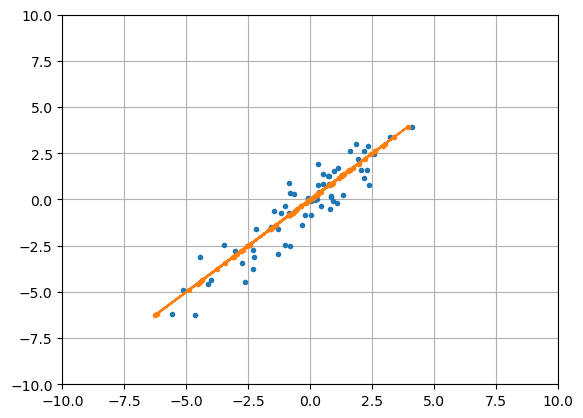

In [7]:
# check the data (noisy y vs mean prediction)
plt.plot(xs[:,0] + 2 * xs[:,1], ys, marker = '.', linestyle = 'none')
plt.plot(ys, ys, marker = '.', label = 'y=x')
plt.xlim(-10.0, 10.0)
plt.ylim(-10.0, 10.0)
plt.grid()


0 0.0
5 0.12
10 0.25
15 0.38
20 0.5
25 0.62
30 0.75
35 0.88
40 1.0
45 1.12
50 1.25
55 1.38
60 1.5
65 1.62
70 1.75
75 1.88


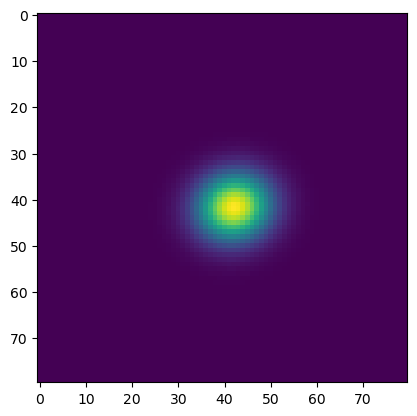

In [8]:
import matplotlib.pyplot as plt                       

# evaluate likelihood on grid
im = np.zeros([80, 80])

gxs = np.arange(0.0, 2.0, 0.025)
gys = np.arange(1.0, 3.0, 0.025)
for xi, x in enumerate(gxs):
    if (xi % 5) == 0:
        print(xi,round(x,2))
    for yi,y in enumerate(gys):
        state = LinearScalar(torch.tensor([x,y]))
        im[xi,yi] = ufn(state, list(range(64))).item()


plt.imshow(np.exp(im - im.max()))

In [9]:
# Run MALA HINTS and check unbiased likelihood

In [10]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults


if True:
    args.levels = 3
    args.design = np.array([1, 4, 4, 4])
    aa = False
    sd = 0.1
else:
    args.levels = 0
    args.design = np.array([64])
    NUM_SCENARIOS = args.design.prod()
    aa = False
    sd = 1.0
    
NUM_SCENARIOS = args.design.prod()

print(NUM_SCENARIOS)

# design now has levels + 1 entries: so we can give a minibatch size in design[0]
# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.epsilon = 0.05 # for HMC
args.L = 4
print(args.__dict__)





64
{'levels': 3, 'design': array([1, 4, 4, 4]), 'additive': True, 'T': 1.0, 'dT': 0.0, 'epsilon': 0.05, 'L': 4}


In [11]:
# test that we have a true Hamiltonian (as epsilon gets small prob accept tends to 1)
# (test for L=1 and L>1)
import copy
torch.manual_seed(0)
args2 = copy.deepcopy(args)
#args2.epsilon /= (100 * args.L) # do this to make Hamiltonian more precise
print(args2.epsilon)
g = TorchLinearScalar(xs, ys)
hmc_test = HINTS_HMC(args2, g, noise_sd = 1.0) # noise sd is now ignored
state = g.sample_initial_state()
print(hmc_test.ns)
print(hmc_test.scenarios(0, 0))
state, correction = hmc_test.primitive_move(state, index = 0, always_accept = False, verbose =  True)
print(state.mu, correction)

0.05
2 64 1 64
RESET
3
[ 1  4 16 64]
64
[1. 1. 1. 1.]
[ 1  4 16 64]
[0]
1
0
gradient =  tensor([0.5579, 0.7852])
initial correction =  -1.2303847641796768
momentum =  tensor([ 1.5549, -0.2738])
proposal =  tensor([ 0.0777, -0.0137])
updated:
Parameter containing:
tensor([ 0.0777, -0.0137], requires_grad=True)
counter 1
momentum after second half step =  tensor([ 1.5688, -0.2543])
1
Gradient shape torch.Size([2])
gradient =  tensor([0.5551, 0.7812])
momentum =  tensor([ 1.5827, -0.2347])
proposal =  tensor([ 0.1569, -0.0254])
updated:
Parameter containing:
tensor([ 0.1569, -0.0254], requires_grad=True)
counter 2
momentum after second half step =  tensor([ 1.5965, -0.2153])
2
Gradient shape torch.Size([2])
gradient =  tensor([0.5521, 0.7770])
momentum =  tensor([ 1.6103, -0.1959])
proposal =  tensor([ 0.2374, -0.0352])
updated:
Parameter containing:
tensor([ 0.2374, -0.0352], requires_grad=True)
counter 3
momentum after second half step =  tensor([ 1.6240, -0.1766])
3
Gradient shape torc

In [12]:
g = TorchLinearScalar(xs, ys)
hmc = HINTS_HMC(args, g, noise_sd = sd) # noise sd crucial for acceptance rate (check maths for sd not equal to 1
state  = g.sample_initial_state()
print(state.mu)

2 64 1 64
RESET
3
[ 1  4 16 64]
64
[1. 1. 1. 1.]
Parameter containing:
tensor([0., 0.], requires_grad=True)


In [19]:
t = 0
time0 = time.time()
now = time0
samp = []
run_time_mins = 5
end_time = time0 + 60.0 * run_time_mins
while (now < end_time):
    hmc.shuffle()
    #print(t)
    #g.evaluate.cache_clear() # risk of revisiting same state and scenario after reject, and gradient not being available
    state, correction = hmc.hints(state, args.levels, always_accept = aa) # e.g. dbg = (t==0)
    samp.append(state.mu.detach())
    t+=1
    now = time.time()
    if (t%100) == 0:
        print("Iteration:{}   Time taken:{}".format(t, round(now - time0, 2)), hmc.acceptances, hmc.rejections)
        print(state.mu)

# print time per evaluation
for (a,r) in zip(hmc.acceptances, hmc.rejections):
    print(a,r, round((a * 100)/(a+r), 2), "%")


Iteration:100   Time taken:4.34 [553791 143824  32342   5536] [38084  4144  4650  3712]
Parameter containing:
tensor([1.0776, 1.8228], requires_grad=True)
Iteration:200   Time taken:8.65 [559804 145385  32693   5589] [38471  4183  4699  3759]
Parameter containing:
tensor([1.2209, 2.0699], requires_grad=True)
Iteration:300   Time taken:14.67 [565774 146930  33048   5650] [38901  4238  4744  3798]
Parameter containing:
tensor([0.9328, 2.1099], requires_grad=True)
Iteration:400   Time taken:18.94 [571755 148479  33390   5713] [39320  4289  4802  3835]
Parameter containing:
tensor([1.0040, 2.0347], requires_grad=True)
Iteration:500   Time taken:23.19 [577754 150014  33744   5764] [39721  4354  4848  3884]
Parameter containing:
tensor([0.8506, 2.0540], requires_grad=True)
Iteration:600   Time taken:27.49 [583728 151574  34101   5828] [40147  4394  4891  3920]
Parameter containing:
tensor([0.9152, 2.0913], requires_grad=True)
Iteration:700   Time taken:33.46 [589714 153132  34454   5885] [40

In [20]:
# scatter the sample
allsamp = torch.stack(samp)


In [21]:
ns = allsamp.shape[0]
print(ns)

6378


Text(0.5, 1.0, 'Zoomed')

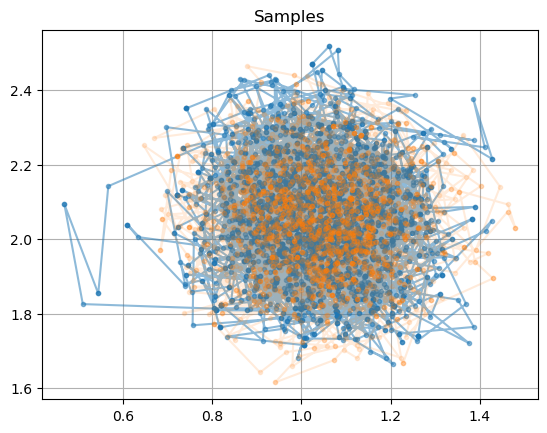

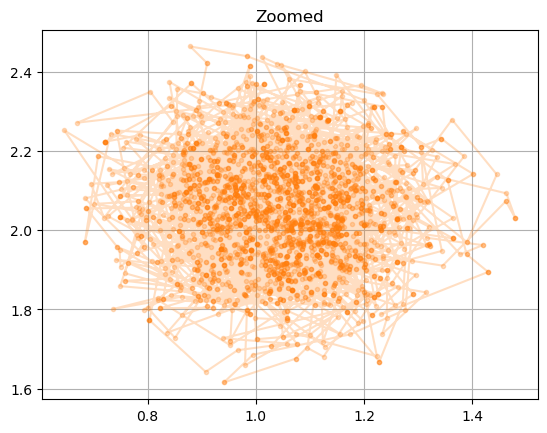

In [26]:
plt.plot(allsamp[:ns//2,0].numpy(), allsamp[:ns//2,1].numpy(), alpha = 0.5, marker = '.', label = 'first half of run')
plt.plot(allsamp[ns//2:,0].numpy(), allsamp[ns//2:,1].numpy(), alpha = 0.15, marker = '.', label = 'second half of run')
plt.grid()
plt.title("Samples")

plt.figure()
plt.plot(allsamp[ns//2:ns//2:, 0].numpy(), allsamp[ns//2:ns//2:,1].numpy(), alpha = 0.25, marker = '.') # skip a colour
plt.plot(allsamp[ns//2:,0].numpy(), allsamp[ns//2:,1].numpy(), alpha = 0.25, marker = '.')
plt.grid()
plt.title("Zoomed")

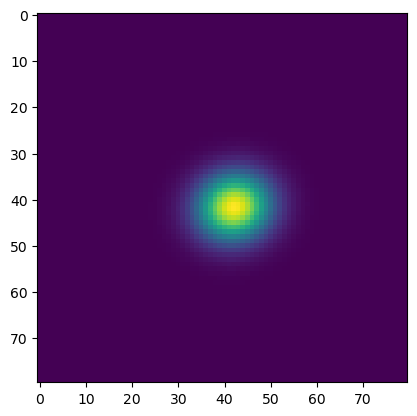

In [27]:
ime = np.exp(im - im.max())
plt.imshow(ime)

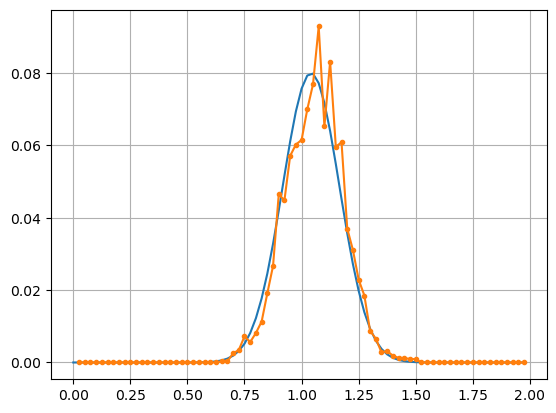

In [28]:
exh = ime.sum(axis = 1)
exh/=exh.sum()
plt.plot(gxs, exh)

# get histograms of marginals? compare with MCMC?
# or analytical posterior... 

counts, edges = np.histogram(allsamp[ns//2:,0], bins = gxs)

plt.plot(edges[1:], counts/float(np.sum(counts)), marker = '.')
plt.grid()


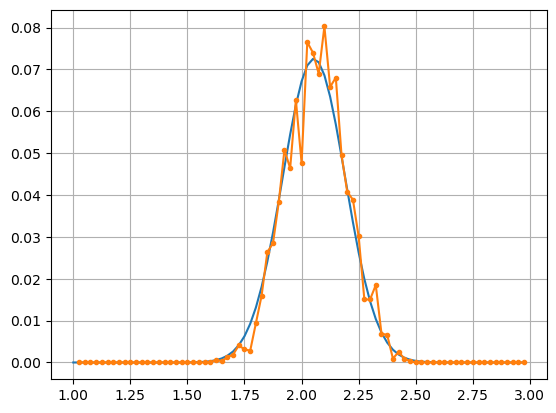

In [29]:
exh = ime.sum(axis = 0)
exh/=exh.sum()
plt.plot(gys, exh)

# get histograms of marginals? compare with MCMC?
# or analytical posterior... 

counts, edges = np.histogram(allsamp[ns//2:,1], bins = gys)

plt.plot(edges[1:], counts/float(np.sum(counts)), marker = '.')
plt.grid()


## Original Logistic Regression example (image recognition)

In [30]:
# first test PyTorch
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
batch_size = 100
#train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 13.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 358kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 20.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [31]:
# Example PyTorch model
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x) # pytorch Crossentropy loss takes scores, not logits as inputs
        #outputs = F.softmax(self.linear(x), dim = -1) # why better without F.softmax
        return outputs 

In [32]:
# was not worth caching this
def get_minibatch(dataset, n, i, input_dim = 784):
    lst1, lst2 = zip(*[dataset[ii] for ii in range(i * n, (i+1) * n)])
    xs = torch.stack(lst1).view(-1, input_dim)
    ys = torch.tensor(lst2)
    return(xs, ys)

In [44]:
%%time
# logistic regression standard training (non Bayesian)
input_dim = 784
output_dim = 10

criterion = torch.nn.CrossEntropyLoss(reduction = 'sum') # computes softmax and then the cross entropy
model = LogisticRegression(input_dim, output_dim)
lr_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate) # SToch Gdt Descent
N = train_dataset.__len__()//batch_size # TO DO: get N from dataset
print(N)
epochs = 4 #n_iters / (len(train_dataset) / batch_size)
i = 0
for epoch in range(int(epochs)):
    epoch_losses = []
    for it in range(N):
        optimizer.zero_grad()
        images, labels = get_minibatch(train_dataset, batch_size, it)    
        outputs = model(images)
        loss = criterion(outputs, labels) # NEXT STEP: replace with an evaluate call!!!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().item())
        i += 1
    # end of epoch: calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images)
        # TO DO convert these outputs to probs, to get more accurate Accuracy metric
        # and to support historical averaging (e.g. q(n) = p(n) * 2/(n+1) + q(n-1) * (n-1)/(n+1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * float(correct)/total
    print("Iteration: {}. Loss: {:1f}. Accuracy: {}.".format(i, torch.tensor(epoch_losses).mean(), accuracy))

600
Iteration: 600. Loss: 53.456482. Accuracy: 90.19.
Iteration: 1200. Loss: 35.934698. Accuracy: 91.08.
Iteration: 1800. Loss: 33.139638. Accuracy: 91.44.
Iteration: 2400. Loss: 31.677691. Accuracy: 91.64.
CPU times: user 7.99 s, sys: 452 ms, total: 8.44 s
Wall time: 7.2 s


In [45]:
# Create the user function for HINTS

device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU slightly reduces minibatch wall clock time (100)

class TorchMNIST(UserFn):
        def __init__(self, additive = True):
            self.batch_size = 100 # 60000 dataset size (so will not see many GPU benefits)
            self.input_dim = 784
            self.output_dim = 10
            self.train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
            self.N = self.train_dataset.__len__()//self.batch_size # num scenarios
            self.lr = 0.001 # TO DO pass this parameter
            self.additive = additive # used by HINTS
            print(self.N)
            self.criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')
            #self.calls = [] # for cache stats
            super().__init__(None)
        #
        def sample_initial_state(self):
            model = LogisticRegression(self.input_dim, self.output_dim).to(device)
            return(model)
        #    
        @lru_cache(maxsize = 1000000)
        def evaluate(self, state, term_index, gradient = False):
            #self.calls.append((hash(self), hash(state), hash(term_index), hash(gradient)))
            self.counter += 1
            if gradient:
                f = -self.minibatch_loss(state, term_index)
                f.backward()
            else:
                with torch.no_grad():
                    f = -self.minibatch_loss(state, term_index)
            return(f)
        #
        # this can be called with or without torch.no_grad
        def minibatch_loss(self, model, term_index):
            images, labels = get_minibatch(self.train_dataset, self.batch_size, term_index)  
            outputs = model(images.to(device))
            loss = self.criterion(outputs.cpu(), labels) # NEXT STEP: replace with an evaluate call!!!
            return(loss)



In [46]:
# test it   
MH = TorchMNIST()
state0 = MH.sample_initial_state()
state1 = state0
%time v = MH.evaluate(state0, 6, True)
%time v = MH.evaluate(state1, 6, True) # cached: should be faster
print(v)
for f in state0.parameters():
    print(f.shape, f.grad.shape)

600
CPU times: user 3.71 ms, sys: 0 ns, total: 3.71 ms
Wall time: 3.25 ms
CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 3.34 μs
tensor(-232.1230, grad_fn=<NegBackward0>)
torch.Size([10, 784]) torch.Size([10, 784])
torch.Size([10]) torch.Size([10])


In [47]:
%%time
# MINIBATCH SGD EXAMPLE (no HINTS yet)
epochs = 4
lr_rate = 0.001
model = MH.sample_initial_state()
optimizer = torch.optim.SGD(model.parameters(), lr = lr_rate)
i = 0
for epoch in range(int(epochs)):
    epoch_losses = []
    for it in range(MH.N):
        optimizer.zero_grad()
        loss = MH.minibatch_loss(model, it).cpu()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().item())
        i += 1
    # end of epoch: calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images.to(device)).cpu()
        # TO DO convert these outputs to probs, to get more accurate Accuracy metric
        # and to support historical averaging (e.g. q(n) = p(n) * 2/(n+1) + q(n-1) * (n-1)/(n+1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * float(correct)/total
    print("Iteration: {}. Loss: {:1f}. Accuracy: {}.".format(i, torch.tensor(epoch_losses).mean(), accuracy))



Iteration: 600. Loss: 53.392695. Accuracy: 90.2.
Iteration: 1200. Loss: 35.952797. Accuracy: 90.94.
Iteration: 1800. Loss: 33.153756. Accuracy: 91.33.
Iteration: 2400. Loss: 31.688344. Accuracy: 91.59.
CPU times: user 7.88 s, sys: 395 ms, total: 8.27 s
Wall time: 7.04 s


In [48]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults


if True: # set to True for HINTS
    args.levels = 6
    log_branch_factor = 1
    N_0 = 1
    args.design = np.array([1,2,3,2,5,2,5])
    NUM_SCENARIOS = args.design.prod()
    aa = False
    sd = 1.0
elif True: # test Langevin MCMC first (or set sd to small value for SGD)
    args.levels = 1 
    NUM_SCENARIOS = 600 # Langevin / SGD
    args.design = np.array([1,NUM_SCENARIOS]) # ensure whole dataset is covered
    aa = True # use always_accept flag to get minibatch Langevin (so we actually only have  a 1 level architecture) - TOP LEVEL ALWAYS ACCEPT
    sd = 0.001
else: # FULL DATASET (not minibatch) Langevin/gradient descent
    args.levels = 0 
    NUM_SCENARIOS = 600 # 600 for naive mcmc, 1 for SGD
    args.design = np.array([NUM_SCENARIOS]) # ensure whole dataset is covered
    aa = True # always accept only applies to TOP LEVEL
    sd = 0.001
    
print(NUM_SCENARIOS)

# design now has levels + 1 entries: so we can give a minibatch size in design[0]
# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.epsilon = 0.001 # for HMC
args.L = 1 # HMC steps
print(args.__dict__)


g = TorchMNIST(args.additive)
hmc = HINTS_HMC(args, g, noise_sd = sd) # noise sd crucial for acceptance rate (check maths for sd not equal to 1
state  = g.sample_initial_state()
print(state)



600
{'levels': 6, 'design': array([1, 2, 3, 2, 5, 2, 5]), 'additive': True, 'T': 1.0, 'dT': 0.0, 'epsilon': 0.001, 'L': 1}
600
RESET
6
[  1   2   6  12  60 120 600]
600
[1. 1. 1. 1. 1. 1. 1.]
LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [51]:
# test that we have a true Hamiltonian (as epsilon gets small prob accept tends to 1)
# (test for L=1 and L>1)
import copy
torch.manual_seed(0)
args2 = copy.deepcopy(args)
args2.epsilon /= (100 * args.L) # do this to make Hamiltonian more precise
print(args2.epsilon)
g = TorchMNIST(args.additive)
hmc_test = HINTS_HMC(args2, g, noise_sd = 1.0) # noise sd is now ignored
state = g.sample_initial_state()
print(hmc_test.ns)
print(hmc_test.scenarios(0, 0))
state, correction = hmc_test.primitive_move(state, index = 0, always_accept = False, verbose =  True)
print(correction)

1e-05
600
RESET
6
[  1   2   6  12  60 120 600]
600
[1. 1. 1. 1. 1. 1. 1.]
[  1   2   6  12  60 120 600]
[0]
1
0
gradient =  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
initial correction =  -3939.285520121741
momentum =  tensor([[ 0.1571, -0.0740, -0.3431,  ...,  0.3503,  0.5977, -0.5300],
        [ 0.3233,  1.8814,  0.8823,  ..., -0.3382,  0.4039,  0.3145],
        [ 0.9249,  0.3335,  1.0188,  ...,  0.6947, -0.3591, -0.0235],
        ...,
        [-0.0408,  0.4031, -1.5479,  ...,  0.2294, -0.7482, -0.4704],
        [-0.0570,  0.7583, -0.2993,  ...,  1.9096,  0.3542,  0.1955],
        [ 0.1193,  0.3190,  0.6423,  ..., -0.6517, -0.8339, -1.6995]])
proposal =  tensor([[ 0.0336,  0.0148, -0.0029,  ..., -0.0143, -0.0238, -0.0120],
        [ 0.0174, -0.0162,  0.0356,  ...,  0.0019, -

In [52]:
t = 0
time0 = time.time()
print(time0)
now = time0
then = now
while (now < (time0 + 1800.0)):
    hmc.shuffle()
    print(t)
    g.evaluate.cache_clear() # risk of revisiting same state and scenario after reject, and gradient not being available [NOT NEEDED?? IF ALWAYS EVAL WITH GDT]
    state, correction = hmc.hints(state, args.levels, always_accept = aa) # e.g. dbg = (t==0)
    # diagnostic histogram
    # show progress
    prev_then = then
    then = time.time()
    t+=1
    if True:
        with torch.no_grad():
            loss = MH.minibatch_loss(state, (t-1) % NUM_SCENARIOS)
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = Variable(images.view(-1, 28*28))
            outputs = state(images.to(device))
            # TO DO convert these outputs to probs, to get more accurate Accuracy metric
            # and to support historical averaging (e.g. q(n) = p(n) * 2/(n+1) + q(n-1) * (n-1)/(n+1))
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            # for gpu, bring the predicted and labels back to cpu fro python operations to work
            correct+= (predicted == labels).sum()
        accuracy = 100 * float(correct)/total
        prev_now = now
        now = time.time()
        print("Iteration: {}. Train time:{}. Test time:{}. Noisy loss: {}. Accuracy: {}."\
              .format(t, round(then - prev_now, 2), round(now - then, 2), round(loss.item(),2), accuracy), hmc.acceptances, hmc.rejections)
    else:
        now = time.time()
        print("Iteration: {}. Time taken:{}."\
              .format(t, round(then - prev_then, 2), hmc.acceptances, hmc.rejections))

# print time per evaluation
hmc.acceptances.sum()


1747652554.5800822
0
Iteration: 1. Train time:14.86. Test time:0.24. Noisy loss: 221.33. Accuracy: 17.1. [40253 19628  5826  2815   507   329    68] [691 844 998 596 175  12   0]
1
Iteration: 2. Train time:14.71. Test time:0.25. Noisy loss: 216.98. Accuracy: 25.94. [40835 19912  5901  2856   517   334    69] [ 709  860 1023  605  175   12    0]
2
Iteration: 3. Train time:14.93. Test time:0.24. Noisy loss: 206.13. Accuracy: 35.57. [41421 20197  5985  2898   527   339    70] [ 723  875 1039  613  175   12    0]
3
Iteration: 4. Train time:14.53. Test time:0.24. Noisy loss: 193.76. Accuracy: 41.87. [42005 20474  6066  2936   536   344    71] [ 739  898 1058  625  176   12    0]
4
Iteration: 5. Train time:14.81. Test time:0.23. Noisy loss: 192.54. Accuracy: 46.04. [42592 20749  6152  2980   546   349    72] [ 752  923 1072  631  176   12    0]
5
Iteration: 6. Train time:14.89. Test time:0.23. Noisy loss: 194.42. Accuracy: 49.11. [43180 21040  6243  3022   556   354    73] [ 764  932 1081  6

197158

In [100]:
# NB steps are too small if we are not seeing occasional rejection at root - params would need tuning

In [59]:
# cache making no difference
print(hmc.fn.total_counter, hmc.fn.counter, "miss% = " + str(int((100.0 * hmc.fn.counter)/ hmc.fn.total_counter))) # check cache ratio
#(len(set(g.calls)), len(g.calls)) # check potential gain from cache

1622820 1139859 miss% = 70


In [60]:
hmc.fn.evaluate.cache_info()

CacheInfo(hits=2640, misses=5760, maxsize=1000000, currsize=5760)

In [ ]:
# PRE 2025 comments
# looks to be better than MCMC [but for this dataset, no compelling case for MCMC methods]
# HOW MUCH NOISE AT PRIMITIVE LEVEL? - zero case for SGD
# aim for bigger moves at primitive level (or HMC chain?)
# GPU - DONE
# Bayesian accuracy measure e.g thru decaying average (triangle distrib)
